This notebook plots a qubit and the control

In [2]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.figsize"] = [10, 5]
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 14

import jax.numpy as jnp
import jax

In [3]:
pauli_x = [[0., 1.], [1., 0.]]
pauli_y = [[0., -1.j], [1.j, 0.]]
pauli_z = [[1., 0.], [0., -1.]]

pauli = jnp.asarray([pauli_x, pauli_y, pauli_z], dtype=complex)

basis = jnp.asarray([
    [[1, 0], [0, 0]],
    [[0, 1], [0, 0]],
    [[0, 0], [1, 0]],
    [[0, 0], [0, 1]],
])

Here we simulate the following quantum evolution:
$$
\begin{align}
H = & \omega_0\sigma_z + h(t) \sigma_x
\end{align}
$$

In [4]:
# Determininstic evolution
omega0 = 1.
hamiltonian0 = omega0*pauli[2]

# Initial conditions
psi0 = jnp.asarray([1, 0], dtype=complex)

# Cost function
O_target = -pauli[1]

# Set-up simulation
times = jnp.linspace(0, 0.85, 80)

def impulse_function(x):
    a, b = 1.18363, 3.61284
    h = -0.820075
    if x < a:
        return 0.
    elif x < b:
        return h
    else:
        return 0.
    
control = [impulse_function(t) for t in times]

control = Θ=[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.5845552297165204, -0.003910068426197455, -0.019550342130987275, 0.003910068426197455, 0.011730205278592365, -0.003910068426197455, -0.003910068426197455, 0.011730205278592365, -0.003910068426197455, -0.003910068426197455, -0.011730205278592365, 0.003910068426197455, 0.003910068426197455, 0.011730205278592365, -0.003910068426197455, -0.003910068426197455, -0.003910068426197455, 0.003910068426197455, -0.011730205278592365, 0.003910068426197455, 0.011730205278592365, -0.003910068426197455, -0.011730205278592365, 0.019550342130987275, -0.003910068426197455, -0.011730205278592365, 0.011730205278592365, -0.019550342130987275, 0.019550342130987275, -0.011730205278592365, 0.003910068426197455, 0.003910068426197455, -0.011730205278592365, 0.003910068426197455, 0.003910068426197455, 0.011730205278592365, -0.011730205278592365, 0.003910068426197455, -0.003910068426197455, 0.003910068426197455, -0.011730205278592365, 0.003910068426197455, 0.003910068426197455, 0.003910068426197455, -0.003910068426197455, 0.003910068426197455, -0.003910068426197455, 0.003910068426197455, -0.003910068426197455, 0.003910068426197455, -0.003910068426197455, 0.003910068426197455, -0.011730205278592365, 0.003910068426197455, 0.011730205278592365, -0.011730205278592365, 0.011730205278592365, -0.003910068426197455, -0.003910068426197455, 0.003910068426197455, -0.003910068426197455, 0.1133919843597262]
    
if len(control) == len(times):
    print('Congruent arrays')

Congruent arrays


In [5]:
# Run simulation
psi_data = [psi0]
psi = psi_data[0]

for idx in range(1, len(times)):
    
    t = times[idx]
    dt = times[idx] - times[idx-1]

    # Time evolution
    field = control[idx] # Protocol0
    hamiltonian = hamiltonian0 + field * pauli[0]
    gate = jax.scipy.linalg.expm(-1.0j * hamiltonian * dt)
    psi = jnp.einsum('ij, j -> i', gate, psi)
    psi = psi / jnp.linalg.norm(psi) # Normalise
    
    psi_data.append(psi)
    
    


In [6]:
# Plot the state evolution
bloch_sphere_data = [jnp.einsum('i, aij, j -> a', jnp.conj(psi), pauli, psi) for psi in psi_data]

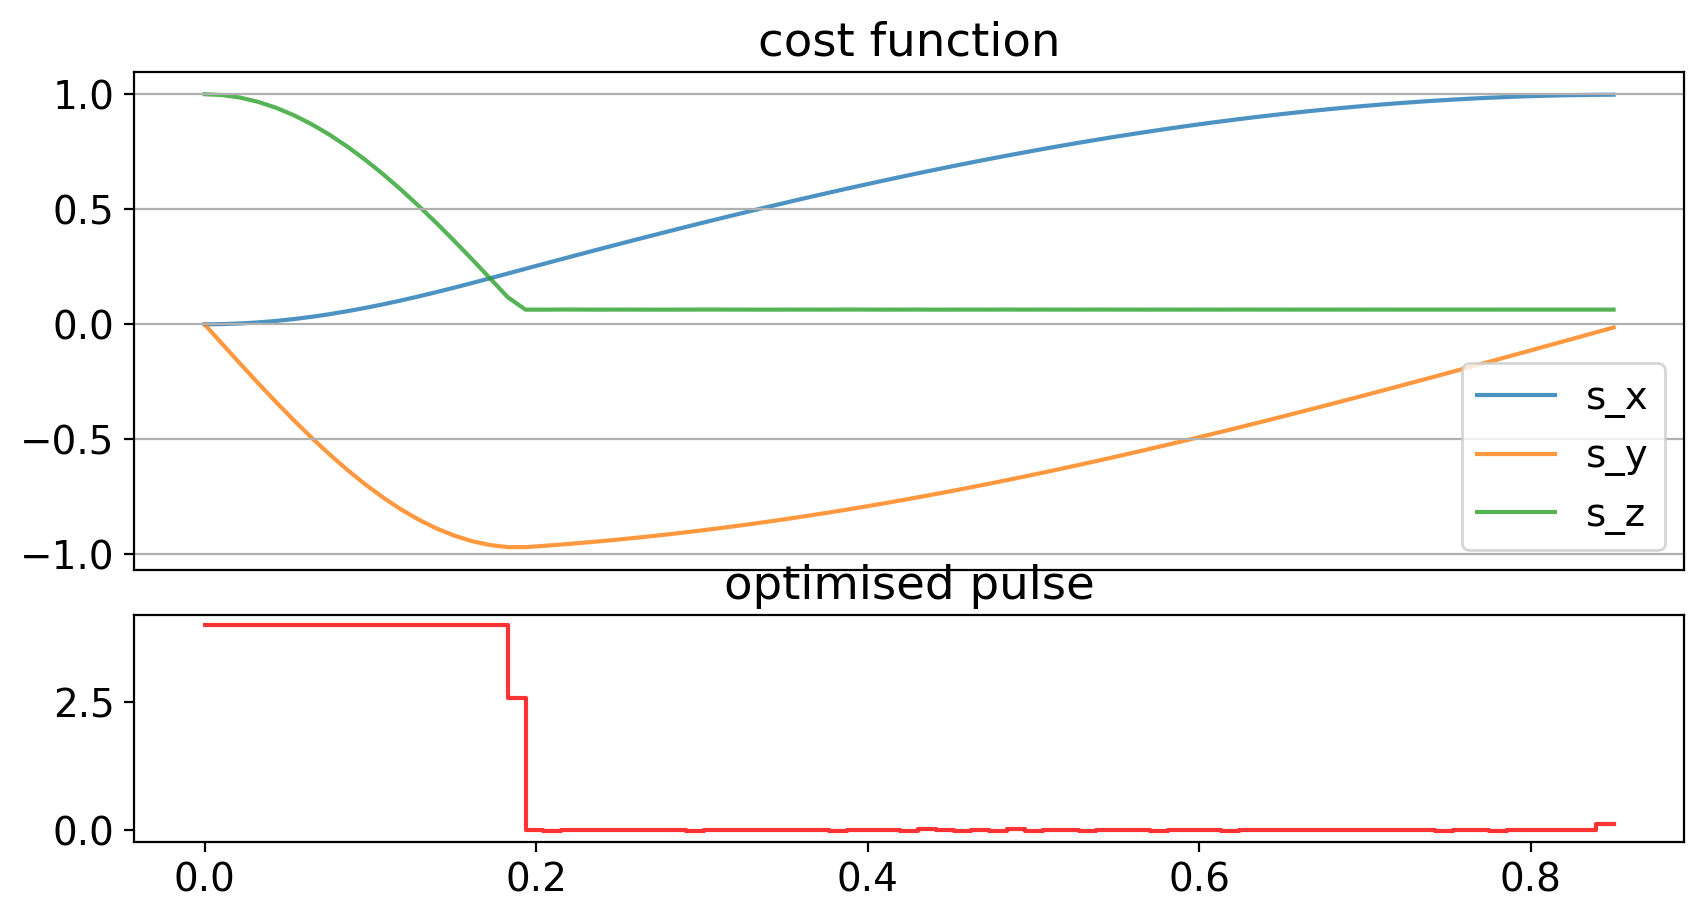

<Figure size 1200x1200 with 0 Axes>

In [8]:
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2, colspan=1)
plt.title('cost function')
plt.grid()

ax1.plot(times, jnp.real(jnp.asarray(bloch_sphere_data)[:,0]), alpha=0.8, label='s_x', zorder=1)
ax1.plot(times, jnp.real(jnp.asarray(bloch_sphere_data)[:,1]), alpha=0.8, label='s_y', zorder=1)
ax1.plot(times, jnp.real(jnp.asarray(bloch_sphere_data)[:,2]), alpha=0.8, label='s_z', zorder=1)
ax1.legend()

# remove timestamps
ax1.axes.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 1), (2, 0), rowspan=1, colspan=1)
plt.title('optimised pulse')
plt.step(times, control, alpha=0.8, label='h(t)', color='r')

plt.figure(figsize=(12, 12))

plt.show(ax1, ax2)



In [9]:
# On the Bloch Sphere

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import numpy as np

def bloch_sphere():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("equal")


    # Make data
    r = 1
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = r * np.outer(np.cos(u), np.sin(v))
    y = r * np.outer(np.sin(u), np.sin(v))
    z = r * np.outer(np.ones(np.size(u)), np.cos(v))

    # Plot the surface
    ax.plot_surface(x, y, z, color='linen', alpha=0.2)

    # plot circular curves over the surface
    theta = np.linspace(0, 2 * np.pi, 100)
    z = np.zeros(100)
    x = r * np.sin(theta)
    y = r * np.cos(theta)

    ax.plot(x, y, z, color='black', alpha=0.50)
    ax.plot(y, z, x, color='black', alpha=0.50)

    ## add axis lines
    zeros = np.zeros(1000)
    line = np.linspace(-r,r,1000)

    ax.plot(line, zeros, zeros, color='black', alpha=0.50)
    ax.plot(zeros, line, zeros, color='black', alpha=0.50)
    ax.plot(zeros, zeros, line, color='black', alpha=0.50)

    # draw a point
    eps = 0.2
    ax.text(1+eps,0,0,'$x$')
    ax.text(0,1+eps,0,'$y$')
    ax.text(0,0,1+eps,'$+z$')
    ax.text(0,0,-1-eps,'$-z$')


    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)


    ax.set_axis_off()
    ax.azim = 45

    return fig, ax

MovieWriter ffmpeg unavailable; using Pillow instead.


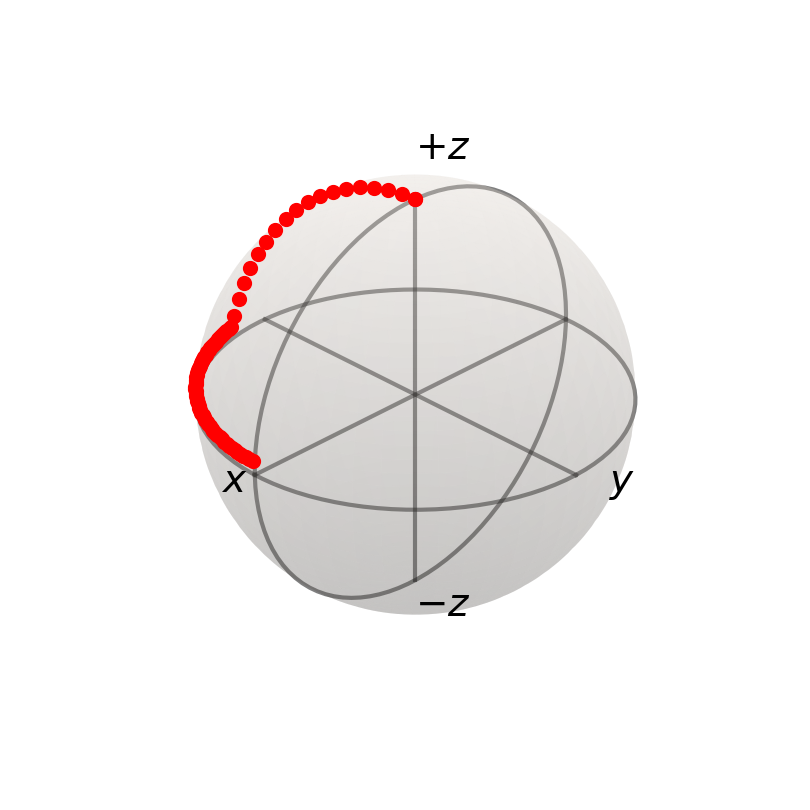

In [10]:
# Plotting

fig, ax = bloch_sphere()
# Animation

N = len(bloch_sphere_data)

# points on bloch sphere
points = jnp.asarray(bloch_sphere_data)
points = jnp.real(points)


def update(num):
    tail_len = 0
    tail_index = max(num - tail_len, 0)
    head_index = max(num - 1, 0)
    ax.scatter(points[tail_index:head_index, 0], points[tail_index:head_index, 1], points[tail_index:head_index, 2], alpha = 0.1, color='k')
    ax.scatter(points[num, 0], points[num, 1], points[num, 2], color='r')

ani = animation.FuncAnimation(fig, update, N, interval=1000/N, blit=False)
ani.save('my_animation6.gif')
plt.show()

In [31]:
bloch_sphere_data[-2]

Array([ 0.05502526+0.j, -0.9955874 +0.j, -0.07599235+0.j], dtype=complex64)